# Author:Harman Kaur
## GRIP@The Sparks Foundation
## Task: Stock Market prediction using numerical and textual analysis
 In this task I created a hybrid model for stock price/performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines.  


In [1]:
!pip install pandas-datareader
!pip install pmdarima
!pip install textBlob
!pip install vaderSentiment

## Stock Market Prediction

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import datetime
import seaborn as sns


### Importing Stocks Data from Web and performing Exploratory Analysis

In [3]:
start=datetime.datetime(2015,6,6)
end=datetime.datetime.today()


In [4]:
stock=web.DataReader("^BSESN",'yahoo',start,end)

In [5]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1479 entries, 2015-06-08 to 2021-06-15
Data columns (total 6 columns):
High         1479 non-null float64
Low          1479 non-null float64
Open         1479 non-null float64
Close        1479 non-null float64
Volume       1479 non-null float64
Adj Close    1479 non-null float64
dtypes: float64(6)
memory usage: 80.9 KB


In [5]:
stock.reset_index(inplace=True)

In [6]:
stock.tail()

,Date,High,Low,Open,Close,Volume,Adj Close
1474,2021-06-09,52446.921875,51717.070312,52401.410156,51941.640625,15200.0,51941.640625
1475,2021-06-10,52346.351562,51957.921875,52143.898438,52300.468750,8600.0,52300.468750
1476,2021-06-11,52641.531250,52388.949219,52477.191406,52474.761719,8500.0,52474.761719
1477,2021-06-14,52590.921875,51936.308594,52492.339844,52551.531250,9900.0,52551.531250
1478,2021-06-15,52869.511719,52671.289062,52751.828125,52773.050781,0.0,52773.050781


In [7]:
stock.shape

(1479, 7)

In [8]:
stock.describe()

,High,Low,Open,Close,Volume,Adj Close
count,1479.000000,1479.000000,1479.000000,1479.000000,1.479000e+03,1479.000000
mean,34517.139444,34106.159691,34352.931561,34307.358576,2.297826e+05,34307.358576
std,6877.992617,6794.010254,6850.526979,6841.121987,1.938279e+06,6841.121987
min,23142.960938,22494.609375,23060.390625,22951.830078,0.000000e+00,22951.830078
25%,28264.035156,28012.174805,28159.254883,28135.740234,1.040000e+04,28135.740234
50%,34325.179688,33889.750000,34087.320312,34103.480469,1.390000e+04,34103.480469
75%,38586.738281,38164.275391,38433.400391,38360.324219,1.900000e+04,38360.324219
max,52869.511719,52671.289062,52751.828125,52773.050781,3.181510e+07,52773.050781


### Data Cleaning

In [9]:
stock["Date"]=pd.to_datetime(stock["Date"])

In [10]:
stock.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-06-08,26827.060547,26472.869141,26814.310547,26523.089844,7900.0,26523.089844
1,2015-06-09,26604.650391,26438.320312,26510.289062,26481.250000,11000.0,26481.250000
2,2015-06-10,26934.740234,26493.289062,26517.320312,26840.500000,8400.0,26840.500000
3,2015-06-11,27000.140625,26348.929688,26959.980469,26370.980469,11300.0,26370.980469
4,2015-06-12,26489.580078,26307.070312,26340.320312,26425.300781,9600.0,26425.300781


### Missing Values

In [11]:
stock.isna().sum()

Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

### Visualizing the Closing price of Stock

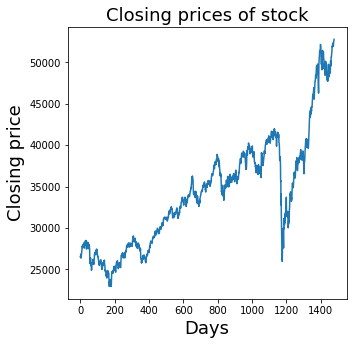

In [12]:
plt.figure(figsize=(5,5))
plt.title("Closing prices of stock",fontsize=18)
plt.xlabel("Days",fontsize=18)
plt.ylabel("Closing price",fontsize=18)
plt.plot(stock["Close"])
plt.show()

### Visualizing the Opening Price of Stock

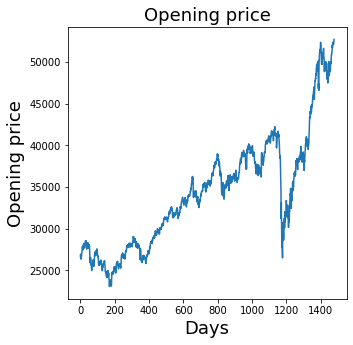

In [13]:
plt.figure(figsize=(5,5))
plt.title("Opening price",fontsize=18)
plt.xlabel("Days",fontsize=18)
plt.ylabel("Opening price",fontsize=18)
plt.plot(stock["Open"])

### Visualizing Stock Returns

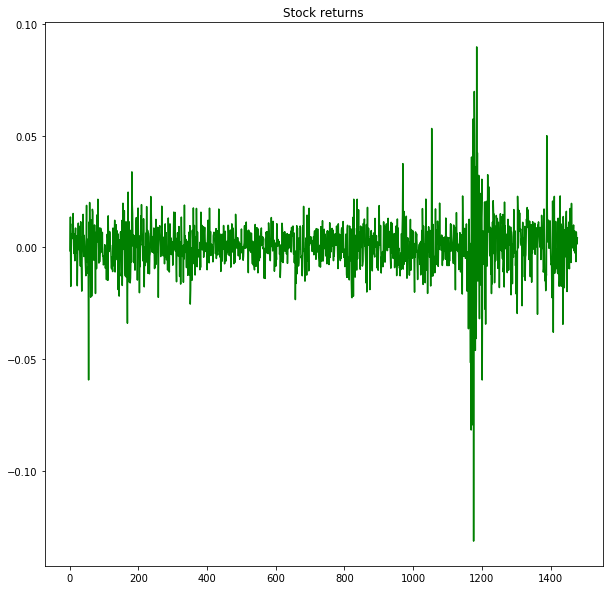

In [14]:
close=stock["Close"]
close=close/close.shift(1)-1
plt.figure(figsize=(10,10))
plt.title("Stock returns")
plt.plot(close,color='g')

In [15]:
train_data=stock[:1000]
test_data=stock[1000:]

## Dickey-Fuller Test

The above time series does not look stationary.To confirm that we will use “Dickey-Fuller test” to determine stationarity.

In [16]:
from statsmodels.tsa.stattools import adfuller

In [17]:
def adfullerTest(x):
    result=adfuller(x)
    print('ADF Statistics:%f'%result[0])
    print('p-value:{}'.format(result[1]))
    print('critical value:')
    for key, value in result[4].items():
	    print('\t%s: %.3f' % (key, value))
    if result[1]<=0.05:
        print("Reject the null hypothesis, i.e time series is stationalry")
    else:
        print("Fail to reject the null hypothesis, i.e the time series is non stationary")


In [18]:
adfullerTest(stock["Close"])

ADF Statistics:0.139197
p-value:0.9686376076430483
critical value:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Fail to reject the null hypothesis, i.e the time series is non stationary


The p-value>0.05, i.e we fail to reject the Null Hypothesis.Hence,the time series is non-stationary.

In [19]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf

Using TensorFlow backend.
C:\Users\500052208\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\500052208\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\500052208\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

In [20]:
np.random.seed(7)

def create_dataset(df2, look_back=1):
	dataX, dataY = [], []
	for i in range(len(df2)-look_back-1):
		a = df2[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(df2[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

df=stock["Close"].to_frame()
print(df.head())

          Close
0  26523.089844
1  26481.250000
2  26840.500000
3  26370.980469
4  26425.300781


## Data Normalization and Division into Training and Test sets

In [21]:
scaler = MinMaxScaler(feature_range=(0, 1))
df2 = scaler.fit_transform(df)

# split into train and test sets
train_size = int(len(df2) * 0.67)
test_size = len(df2) - train_size
train, test = df2[0:train_size,:], df2[train_size:len(df2),:]


In [22]:
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

## Creating a LSTM for Numerical Analysis

In [23]:
# create and fit the LSTM network
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(7, input_shape=(look_back, 1)))
model.add(tf.keras.layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Train on 986 samples
Epoch 1/100
986/986 - 6s - loss: 0.0086
Epoch 2/100
986/986 - 4s - loss: 1.8007e-04
Epoch 3/100
986/986 - 5s - loss: 1.7708e-04
Epoch 4/100
986/986 - 4s - loss: 1.8224e-04
Epoch 5/100
986/986 - 4s - loss: 1.6721e-04
Epoch 6/100
986/986 - 4s - loss: 1.7338e-04
Epoch 7/100
986/986 - 5s - loss: 1.5151e-04
Epoch 8/100
986/986 - 4s - loss: 1.5996e-04
Epoch 9/100
986/986 - 4s - loss: 1.5197e-04
Epoch 10/100
986/986 - 4s - loss: 1.5310e-04
Epoch 11/100
986/986 - 5s - loss: 1.5804e-04
Epoch 12/100
986/986 - 3s - loss: 1.4698e-04
Epoch 13/100
986/986 - 4s - loss: 1.6269e-04
Epoch 14/100
986/986 - 4s - loss: 1.4792e-04
Epoch 15/100
986/986 - 5s - loss: 1.4556e-04
Epoch 16/100
986/986 - 4s - loss: 1.4432e-04
Epoch 17/100
986/986 - 4s - loss: 1.4113e-04
Epoch 18/100
986/986 - 4s - loss: 1.3675e-04
Epoch 19/100
986/986 - 5s - loss: 1.2862e-04
Epoch 20/100
986/986 - 4s - loss: 1.2788e-04
Epoch 21/100
986/986 - 4s - loss: 1.2509e-04
Epoch 22/100
986/986 - 3s - loss: 1.2725e-04
Ep

## Making Predictions

In [24]:
# making predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

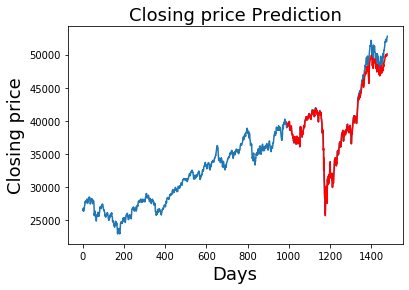

In [25]:
trainPredictPlot = np.empty_like(df2)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df2)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df2)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df2))
plt.plot(testPredictPlot,color='red')
plt.title("Closing price Prediction",fontsize=18)
plt.xlabel("Days",fontsize=18)
plt.ylabel("Closing price",fontsize=18)
plt.show()

In [26]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print("Root mean square error = ",trainScore," RMSE")
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print("Root mean square error = ",testScore," RMSE")

Root mean square error =  251.12437678154535  RMSE
Root mean square error =  972.1159266307385  RMSE


# Analyzing News Dataset

In [27]:
columns = ['Date','Category','News']
news = pd.read_csv('C:\\Users\\500052208\\anaconda python scripts\\india-news-headlines.csv', names = columns)

C:\Users\500052208\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [28]:
news.head()
news.drop(0, inplace=True)
news.drop('Category', axis = 1, inplace=True)
news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3424067 entries, 1 to 3424067
Data columns (total 2 columns):
Date    object
News    object
dtypes: object(2)
memory usage: 78.4+ MB


In [29]:
news['Date'] = pd.to_datetime(news['Date'],format= '%Y%m%d')
news.head()

,Date,News
1,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2,2001-01-02,Fissures in Hurriyat over Pak visit
3,2001-01-02,America's unwanted heading for India?
4,2001-01-02,For bigwigs; it is destination Goa
5,2001-01-02,Extra buses to clear tourist traffic


In [30]:
#Grouping the headlines for each day
news['News'] = news.groupby(['Date']).transform(lambda x : ' '.join(x)) 
news = news.drop_duplicates() 
news.reset_index(inplace = True, drop = True)
news.head()

,Date,News
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-03,Powerless north India gropes in the dark Think...
2,2001-01-04,The string that pulled Stephen Hawking to Indi...
3,2001-01-05,Light combat craft takes India into club class...
4,2001-01-06,Light combat craft takes India into club class...


In [31]:
news['News']

0       Status quo will not be disturbed at Ayodhya; s...
1       Powerless north India gropes in the dark Think...
2       The string that pulled Stephen Hawking to Indi...
3       Light combat craft takes India into club class...
4       Light combat craft takes India into club class...
5       Muslim body rules out talks on Ayodhya Bajrang...
6       Sangh Parivar; Babri panel up the ante Frontru...
7       Financier Bharat Shah held for alleged links w...
8       Fend for yourselves; Pande tells doctors Burea...
9       Sonia takes on the Hindutva brigade Congress h...
10      Govt extends J&K ceasefire by a month Peace hi...
11      Big bath passes without a hitch Security bando...
12      President against pitch for indirect polls TRA...
13      Monster quake kills 4;000 Forces to the rescue...
14      Death; distress; destruction...and it's not ov...
15      More tremors forecast for the next 48 hours Th...
16      Hrithik: Miss Indias' delight! Manoj Bajpai: F...
17      Relief

In [32]:
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import xgboost

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\500052208\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\500052208\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [33]:
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return  TextBlob(text).sentiment.polarity

In [34]:
#Adding subjectivity and polarity columns
news['Subjectivity'] = news['News'].apply(getSubjectivity)
news['Polarity'] = news['News'].apply(getPolarity)
news.head()

,Date,News,Subjectivity,Polarity
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...,0.282333,0.151333
1,2001-01-03,Powerless north India gropes in the dark Think...,0.407692,0.088462
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.446847,0.087961
3,2001-01-05,Light combat craft takes India into club class...,0.476612,0.262024
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485


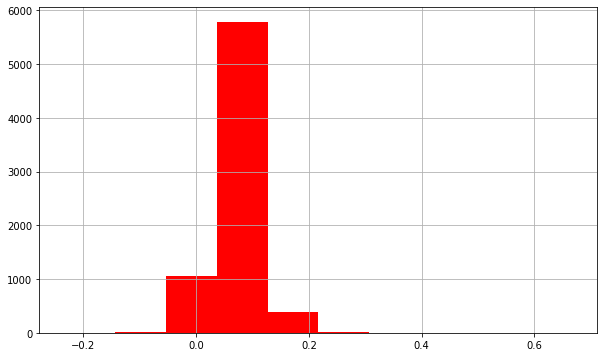

In [35]:
plt.figure(figsize = (10,6))
news['Polarity'].hist(color = 'red')

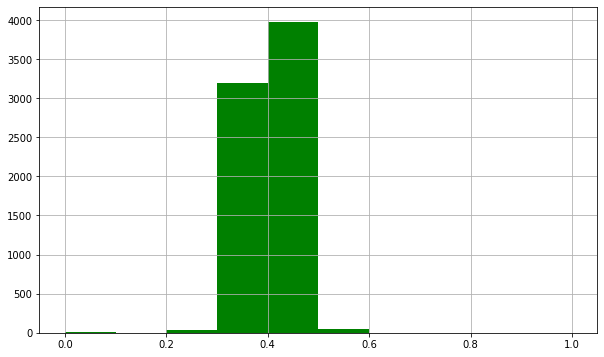

In [36]:
plt.figure(figsize = (10,6))
news['Subjectivity'].hist(color = 'green')

In [39]:
#Adding sentiment score to news
sia = SentimentIntensityAnalyzer()

news['Compound'] = [sia.polarity_scores(v)['compound'] for v in news['News']]
news['Negative'] = [sia.polarity_scores(v)['neg'] for v in news['News']]
news['Neutral'] = [sia.polarity_scores(v)['neu'] for v in news['News']]
news['Positive'] = [sia.polarity_scores(v)['pos'] for v in news['News']]
news.head()

,Date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...,0.282333,0.151333,-0.9811,0.122,0.807,0.071
1,2001-01-03,Powerless north India gropes in the dark Think...,0.407692,0.088462,-0.2640,0.122,0.766,0.111
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.446847,0.087961,0.8738,0.100,0.797,0.103
3,2001-01-05,Light combat craft takes India into club class...,0.476612,0.262024,0.9633,0.124,0.722,0.154
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485,-0.4215,0.152,0.704,0.143


In [40]:
merge = news
merge.head()

,Date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...,0.282333,0.151333,-0.9811,0.122,0.807,0.071
1,2001-01-03,Powerless north India gropes in the dark Think...,0.407692,0.088462,-0.2640,0.122,0.766,0.111
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.446847,0.087961,0.8738,0.100,0.797,0.103
3,2001-01-05,Light combat craft takes India into club class...,0.476612,0.262024,0.9633,0.124,0.722,0.154
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485,-0.4215,0.152,0.704,0.143


In [41]:
dff = merge[['Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral' ,'Positive']]
dff.head()

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.282333,0.151333,-0.9811,0.122,0.807,0.071
1,0.407692,0.088462,-0.2640,0.122,0.766,0.111
2,0.446847,0.087961,0.8738,0.100,0.797,0.103
3,0.476612,0.262024,0.9633,0.124,0.722,0.154
4,0.439394,0.248485,-0.4215,0.152,0.704,0.143


In [42]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
new_df = pd.DataFrame(sc.fit_transform(dff))
new_df.columns = dff.columns
new_df.index = dff.index
new_df.head()

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.282333,0.427407,0.00945,0.274775,0.807,0.116776
1,0.407692,0.357550,0.36800,0.274775,0.766,0.182566
2,0.446847,0.356994,0.93690,0.225225,0.797,0.169408
3,0.476612,0.550397,0.98165,0.279279,0.722,0.253289
4,0.439394,0.535354,0.28925,0.342342,0.704,0.235197


In [54]:
X = new_df[0:1479]
y =stock['Close']
y.head()

0    26523.089844
1    26481.250000
2    26840.500000
3    26370.980469
4    26425.300781
Name: Close, dtype: float64

In [55]:
from sklearn.model_selection import train_test_split

x_train, x_test,y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=0)
x_train.shape

(1183, 6)

In [56]:
x_train[:10]

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
632,0.392424,0.347819,0.00260,0.277027,0.776,0.166118
317,0.384279,0.300876,0.00055,0.342342,0.747,0.166118
1125,0.371321,0.392978,0.00455,0.299550,0.774,0.152961
58,0.430000,0.358642,0.01710,0.355856,0.769,0.121711
241,0.418921,0.246986,0.00030,0.427928,0.742,0.111842
467,0.426120,0.348298,0.00330,0.234234,0.817,0.129934
1099,0.474415,0.221673,0.00120,0.371622,0.731,0.171053
1113,0.443797,0.317398,0.00415,0.243243,0.819,0.120066
1471,0.375895,0.379199,0.80730,0.315315,0.712,0.243421
56,0.520713,0.337221,0.07910,0.299550,0.764,0.169408


In [57]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
prediction=rf.predict(x_test)

In [58]:
print(prediction[:10])
print(y_test[:10])
print("Root mean square error = ",math.sqrt(mean_squared_error(prediction,y_test))," RMSE")

[29653.208125   34123.92439453 42180.27542969 36919.65535156
 34232.25871094 38739.70484375 29033.83412109 26268.79523438
 30306.23804688 30233.09085937]
567     31626.630859
1041    37332.789062
649     35798.011719
666     34010.761719
568     31599.759766
443     29237.150391
175     23788.789062
9       27316.169922
227     25790.220703
771     36351.230469
Name: Close, dtype: float64
Root mean square error =  6318.571056454534  RMSE


In [59]:
adb = AdaBoostRegressor()
adb.fit(x_train, y_train)
predictions = adb.predict(x_test)

In [60]:
print("Root mean square error = ",math.sqrt(mean_squared_error(predictions, y_test))," RMSE")

Root mean square error =  6526.431862413696  RMSE
